# Radioactive Decay

This example is a radioactive decay (`RadioactiveDecay`) problem on simple unit area meshes with a uniform mobile concentration and no boundary condition.

The formulation is:

$$\frac{\partial c_m}{\partial t} =  \nabla \cdot (D \nabla c_m)  - \lambda c_m - \sum \left( -k_i \ c_m \ (n_i - c_{t,i}) + p_i \ c_{t,i} \right)$$

The problem is:
$$
\begin{align}
    \nabla \cdot (D \ \nabla{c}) = 0 &  \quad \text{on }  \Omega  \\
    \sum \left( -k_i \ c_m \ (n_i - c_{t,i}) + p_i \ c_{t,i} \right) = 0 & \quad \text{(no traps)}
\end{align}
$$(problem_decay)

The exact solution for mobile concentration is:

$$
\begin{equation}
    c_\mathrm{exact} = e^{-\lambda t}
\end{equation}
$$(c_exact_fluxes)

We can then run a FESTIM model with these conditions and compare the numerical solution with $c_\mathrm{exact}$.

## FESTIM Code

In [2]:
import festim as F
import numpy as np
from fenics import UnitSquareMesh, MeshFunction
import matplotlib.pyplot as plt

my_model = F.Simulation()

half_life = 0

my_model.initial_conditions = [F.InitialCondition(value=1, field="solute")]

my_model.dt = F.Stepsize(
    initial_value=0.05,
    stepsize_change_ratio=1.01,
    dt_min=1e-05,
)

#ignored
my_model.materials = [F.Material(id=1, D_0=4.1e-07, E_D=0.39)]
my_model.T = F.Temperature(value=300)

def RadioactiveDecayModel1D(half_life):
    # radioactive decay conditions on 1m^3 space
    my_model.mesh = F.MeshFromVertices(np.linspace(0, 1, 1001))

    my_model.sources = [
        F.RadioactiveDecay(decay_constant=np.log(2) / half_life, volume=1)
    ]

    derived_quantities = F.DerivedQuantities([  
        F.TotalVolume("solute", volume=1)
    ])
    my_model.exports = [derived_quantities]

    my_model.settings = F.Settings(
        absolute_tolerance=1e-13,
        relative_tolerance=1e-10,
        final_time=4*half_life  # s
    )

    my_model.initialise()
    my_model.run()

    time = derived_quantities.t
    concentration = derived_quantities[0].data

    return time, concentration

def RadioactiveDecayModel2D(half_life):
    nx, ny = 10, 10
    mesh_fenics = UnitSquareMesh(nx, ny)

    volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
    volume_markers.set_all(1)

    my_model.mesh = F.Mesh(mesh_fenics, volume_markers=volume_markers)

    derived_quantities = F.DerivedQuantities([  
        F.TotalVolume("solute", volume=1)
    ])
    my_model.exports = [derived_quantities]

    my_model.sources = [
        F.RadioactiveDecay(decay_constant=np.log(2) / half_life, volume=1)
    ]

    my_model.settings = F.Settings(
        absolute_tolerance=1e-13,
        relative_tolerance=1e-10,
        final_time=4*half_life  # s
    )

    my_model.initialise()
    my_model.run()

    time = derived_quantities.t
    concentration = derived_quantities[0].data

    return time, concentration

t_1, concentration_1 = RadioactiveDecayModel1D(half_life=50)
t_2, concentration_2 = RadioactiveDecayModel2D(half_life=100)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        2.0e+02 s    Ellapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        4.0e+02 s    Ellapsed time so far: 2.6 s


## Comparison with exact solution

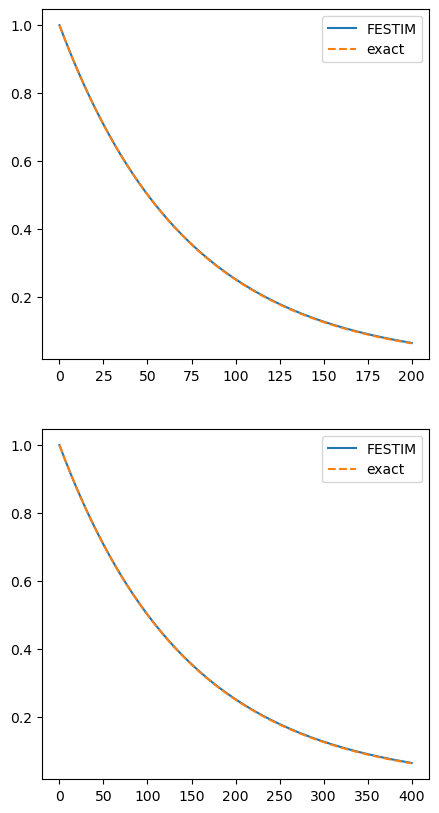

In [5]:
import numpy as np

t_1 = np.array(t_1)
t_2 = np.array(t_2)

exact_1 = np.exp(-np.log(2) / 50 * t_1)
exact_2 = np.exp(-np.log(2) / 100 * t_2)

fig, axs = plt.subplots(2, 1, figsize=(5, 10))

axs[0].plot(t_1, concentration_1, label="FESTIM")
axs[0].plot(t_1, exact_1, linestyle="dashed", label="exact")

axs[0].legend()


axs[1].plot(t_2, concentration_2, label="FESTIM")
axs[1].plot(t_2, exact_2, linestyle="dashed", label="exact")

axs[1].legend();